In [57]:
import numpy as np 
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.stattools as stats
import statsmodels.formula.api as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels as stat
import linearmodels as lm
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import datetime
import hvplot.pandas 
from scipy.stats import norm

# 1. Importing data and cleaning

In [2]:
df = pd.read_csv(r'C:\Users\Mathis Mourey\Downloads\cleandata.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,9,11,12,15,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# get datetime dates and redefine a new dataframe with variable of interest.
ts = pd.to_datetime(df['Geplande datum/tijd'], errors='coerce')
red_df = df[['Pay pax']]
red_df['timestamp'] = ts
red_df

<ipython-input-3-6814d790cb21>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_df['timestamp'] = ts


,Pay pax,timestamp
0,NaN,2021-08-31 08:50:00
1,NaN,2021-08-31 07:00:00
2,NaN,2021-08-31 07:14:00
3,NaN,2021-08-31 06:15:00
4,NaN,2021-08-31 07:10:00
...,...,...
857156,NaN,2021-03-24 10:10:00
857157,NaN,2021-06-11 05:30:00
857158,NaN,2021-03-18 20:00:00
857159,NaN,2020-05-28 13:36:00


<AxesSubplot:xlabel='timestamp'>

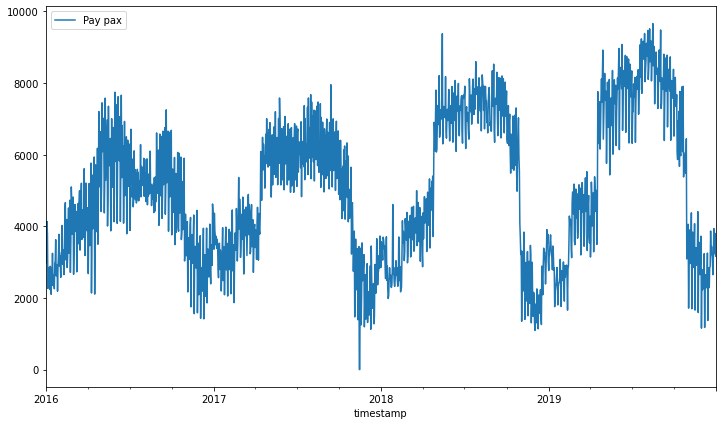

In [87]:
# Visualizing the raw data
data = (red_df.set_index('timestamp')
        .resample('D').sum()
        ['2016':'2019'])
data.plot(figsize=(12,7))

### Features creation

1. Create features for months, days, weeks, etc.

In [88]:
# Function to find the number of the week in a month
def WeekNumber(date_value):
    week = date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1
    return date_value.isocalendar()[1] if week < 0 else week

# Rename for use in the regression
data = data.rename(columns={"Pay pax": "Pay_pax"})

data['Days_of_year'] = data.index.dayofyear
data['Month'] = data.index.month
data['Week'] = data.index.week
data['Week_Month'] = [WeekNumber(i) for i in data.index]
data['Day_Number'] = data.index.day

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['Day_Name'] = data.index.day_name()

data['Time'] = [i for i in range(len(data))]
data['Time2'] = data['Time']**2

data['Pay_pax_L1'] = data['Pay_pax'].shift(-1)
data = data.fillna(0)

# One data point is negative (to be retreated)
data[data['Pay_pax'] < 1] = 1
data

<ipython-input-88-ac6fd0358aae>:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['Week'] = data.index.week


,Pay_pax,Days_of_year,Month,Week,Week_Month,Day_Number,Day_Name,Time,Time2,Pay_pax_L1
timestamp,,,,,,,,,,
2016-01-01,2981.0,1,1,53,1,1,Friday,0,0,3058.0
2016-01-02,3058.0,2,1,53,1,2,Saturday,1,1,4132.0
2016-01-03,4132.0,3,1,53,1,3,Sunday,2,4,3777.0
2016-01-04,3777.0,4,1,1,1,4,Monday,3,9,2266.0
2016-01-05,2266.0,5,1,1,1,5,Tuesday,4,16,2556.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3937.0,361,12,52,5,27,Friday,1456,2119936,3235.0
2019-12-28,3235.0,362,12,52,5,28,Saturday,1457,2122849,3810.0
2019-12-29,3810.0,363,12,52,5,29,Sunday,1458,2125764,3582.0


<AxesSubplot:xlabel='Week_Month'>

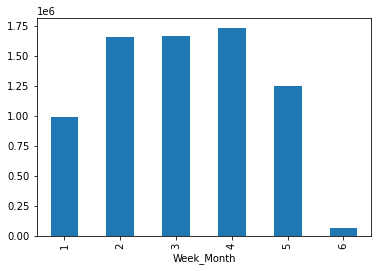

In [89]:
# Visualize possible seasonal effects (monthly, weekly, daily?)
(data.groupby('Week_Month')
 .sum()
 ['Pay_pax']
 .plot.bar())

### Visualizating the dataset

1. Autorcorrelation
2. Normality
3. Stationarity

In [90]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Serie Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sma.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

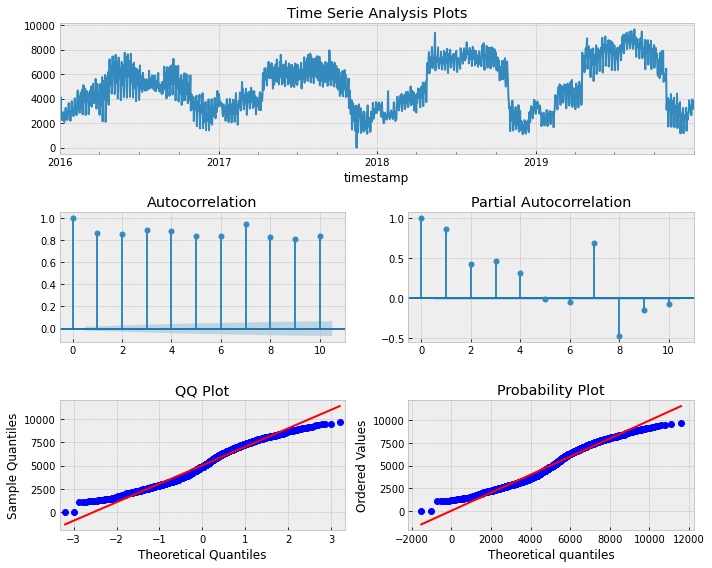

In [91]:
tsplot(data['Pay_pax'], lags=10)

## Creating the training & testing sets + implementing features

In [92]:
#Partition the data into a train and test set
y_to_train = data['2017':'2018'] # dataset to train
y_to_val = data['2019':] # last X months for test  
predict_date = len(data) - len(data[:'2018'])
predict_date

365

In [93]:
#Create dummy variables for each months 
# Comment: dummy variables for days in the week do provide additional predictive power
# Comment: Dummy & radils for periods up and down provide non significant predicitive power

months ={'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
         'July':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

for i in list(months.keys()):
    y_to_train[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_train)) ]
    y_to_val[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_val)) ]
    
#y_to_train['Period_up'] = [1 if (i>3) & (i<10) else 0 for i in y_to_train['Month']]
#y_to_train['Period_down'] = [1 if (i<3) | (i>10) else 0 for i in y_to_train['Month']]
#y_to_val['Period_up'] = [1 if i>3 & i<10 else 0 for i in y_to_val['Month']]
#y_to_val['Period_down'] = [1 if i<3 | i>10 else 0 for i in y_to_val['Month']]

#y_to_train

<ipython-input-93-020b30647dea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_train)) ]
<ipython-input-93-020b30647dea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_val[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_val)) ]


In [94]:
# Check is periods up and down match actual variations 
#y_to_train[['Pay_pax', 'Period_up', 'Period_down']].plot()

# 2. Testing Models to predict the sum of passenger (daily)

### Train the model 1: Linear Regression w/ Time and Dummy Variables for Months

In [95]:
my_formula = "Pay_pax ~ Time2 + "+' + '.join(list(months.keys()))
my_formula

'Pay_pax ~ Time2 + Jan + Feb + Mar + Apr + May + June + July + Aug + Sep + Oct + Nov + Dec'

                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     292.2
Date:                Sun, 18 Sep 2022   Prob (F-statistic):          1.63e-266
Time:                        18:17:11   Log-Likelihood:                -5916.3
No. Observations:                 730   AIC:                         1.186e+04
Df Residuals:                     717   BIC:                         1.192e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4077.5833     65.179     62.560      0.0

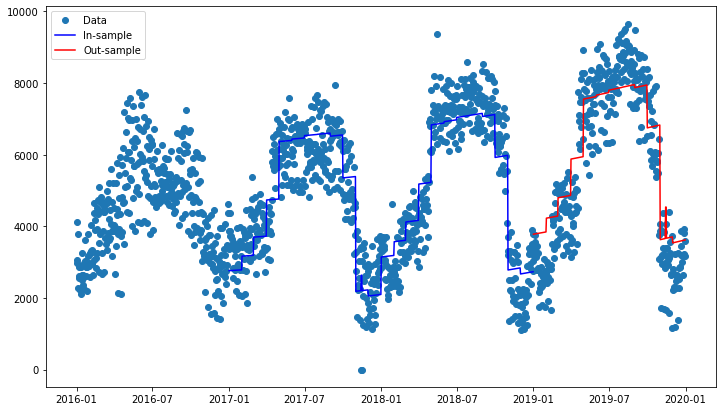

In [97]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
print(rslt.summary())

#insample
ypred = rslt.predict(y_to_train)

#outsample
pred_out = rslt.get_prediction(y_to_val).summary_frame(alpha=0.05)
pred_out = pred_out.set_index(y_to_val.index)
ypred_out = pred_out['mean']
#ypred_UB = pred_out['mean_ci_upper']
#ypred_LB = pred_out['mean_ci_lower']


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")


ax.plot(ypred_out, "r-", label="Out-sample")
#ax.plot(ypred_UB, "r--", label="Out-sample UB")
#ax.plot(ypred_LB, "r--", label="Out-sample LB")

mse2 = ((ypred_out - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

ax.legend(loc="best")

### Train model 2: Linear Regression w/ Time and Radial Variables for Months

In [98]:
# radial dummies 
from sklego.preprocessing import RepeatingBasisFunction as RBF
rbf = RBF(n_periods=12,
             column="Days_of_year",
             input_range=(1,365),
             remainder="drop")


In [99]:
rbf.fit(data)
radials = pd.DataFrame(index=data.index,
               	data=rbf.transform(data))
#radials.plot(subplots=True, figsize=(14, 8),
#     	sharex=True, title="Radial Basis Functions",
#     	legend=False);
radials.columns = list(months.keys())
#radials

In [100]:
y_to_train[list(months.keys())] = radials
y_to_val[list(months.keys())] = radials

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     320.9
Date:                Sun, 18 Sep 2022   Prob (F-statistic):          3.79e-288
Time:                        18:17:39   Log-Likelihood:                -5862.5
No. Observations:                 730   AIC:                         1.175e+04
Df Residuals:                     716   BIC:                         1.182e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.182e+04    3.8e+05      0.031      0.9

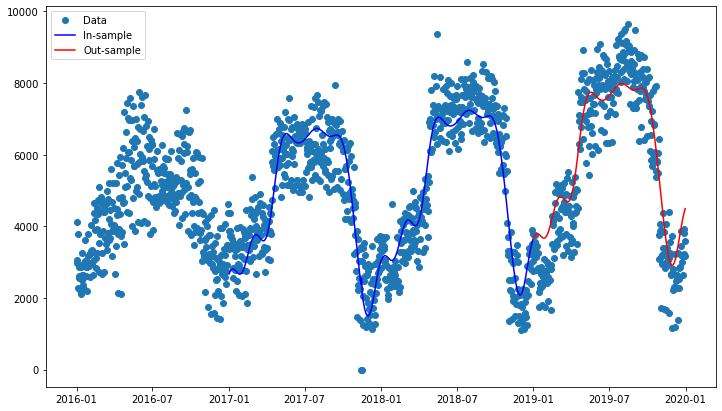

In [101]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
ypred = rslt.predict(y_to_train)
ypred_out = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out, "r-", label="Out-sample")
ax.legend(loc="best")

mse2 = ((ypred_out - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))
    

### Train model 3: Linear Ridge Regression w/ Time and Radial Variables for Months

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


                         QuantReg Regression Results                          
Dep. Variable:                Pay_pax   Pseudo R-squared:               0.6513
Model:                       QuantReg   Bandwidth:                       376.6
Method:                 Least Squares   Sparsity:                        1757.
Date:                Sun, 18 Sep 2022   No. Observations:                  730
Time:                        18:18:22   Df Residuals:                      716
                                        Df Model:                           13
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3771.8390     58.516     64.458      0.000    3656.955    3886.723
Time2          0.0008      0.000      6.866      0.000       0.001       0.001
Jan          605.8647    227.832      2.659      0.008     158.566    1053.164
Feb        -1366.7847    224.667     -6.084      0.0

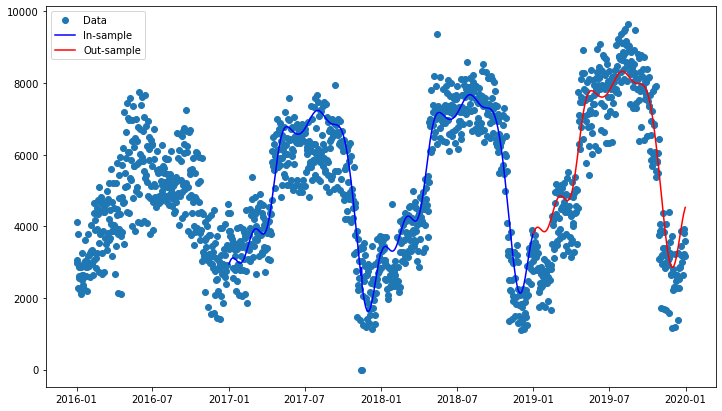

In [102]:
rslt = sm.quantreg(formula=my_formula, data=y_to_train).fit(q=0.6)
ypred = rslt.predict(y_to_train)
ypred_out = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out, "r-", label="Out-sample")
ax.legend(loc="best")

mse2 = ((ypred_out - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

## Testing the Holt-Winter method (additive)

In [103]:
#Set up a function for Holt-Winter's Seasonal Method
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):

    if seasonal_type == 'additive':
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        fcast2_insample = fcast2[:'2017']
        fcast2_outsample = fcast2['2018':]
        mse2 = ((fcast2_outsample - y_to_test['2018':]) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fig, ax = plt.subplots(figsize=(12,7))
        ax.plot(y, "o", label="Data")
        ax.plot(fit2.fittedvalues, "b-", label="In-sample")
        ax.plot(fcast2_outsample, "r-", label="Out-sample")
        ax.legend(loc="best")
    
    
    
    elif seasonal_type == 'multiplicative':  
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        fcast4_insample = fcast4[:'2017']
        fcast4_outsample = fcast4['2018':]
        mse4 = ((fcast4['2018':] - y_to_test['2018':]) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fig, ax = plt.subplots(figsize=(12,7))
        ax.plot(y, "o", label="Data")
        ax.plot(fit4.fittedvalues, "b-", label="In-sample")
        ax.plot(fcast4_outsample, "r-", label="Out-sample")
        ax.legend(loc="best")
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

<ipython-input-103-f9e3e460c961>:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=365 and a Box-Cox transformation 1439.29


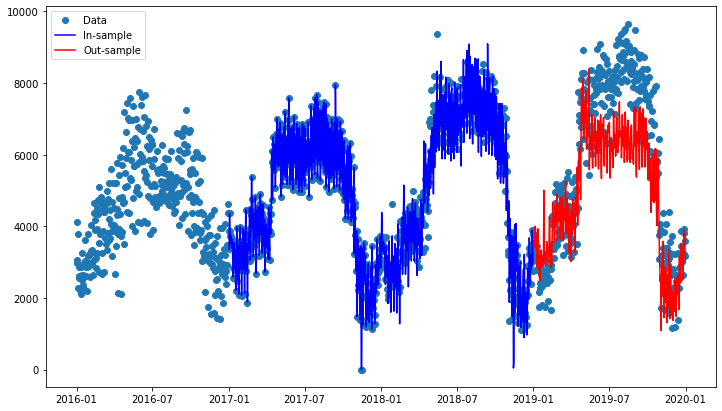

In [104]:
holt_win_sea(data['Pay_pax'], y_to_train['Pay_pax'],y_to_val['Pay_pax'],'additive',365, 365) #Call the function


<ipython-input-103-f9e3e460c961>:22: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=365 and a Box-Cox transformation 1516.84


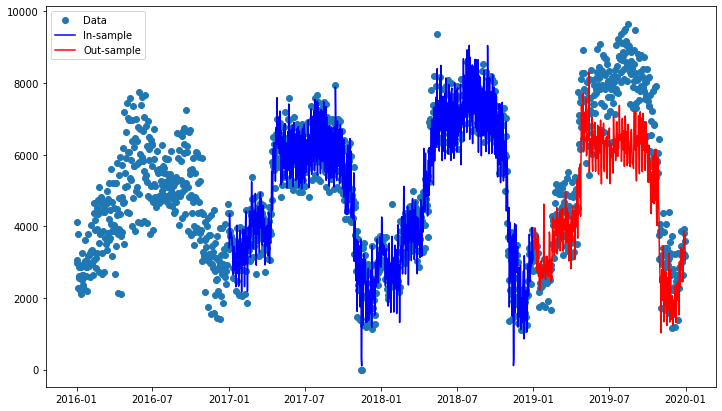

In [105]:
holt_win_sea(data['Pay_pax'], y_to_train['Pay_pax'],y_to_val['Pay_pax'],'multiplicative',365, 365) #Call the function